<a href="https://colab.research.google.com/github/AJAkil/All-things-AI/blob/master/TF_book_Ch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install datasets transformers umap-learn

In [52]:
from datasets import list_datasets, load_dataset
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import pprint as pp
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [4]:
all_datasets = list_datasets()
len(all_datasets)
all_datasets[:10]

['acronym_identification',
 'ade_corpus_v2',
 'adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus',
 'ag_news',
 'ai2_arc',
 'air_dialogue',
 'ajgt_twitter_ar',
 'allegro_reviews']

In [5]:
emotions = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [8]:
print(len(train_ds))
print(train_ds[0])

16000
{'text': 'i didnt feel humiliated', 'label': 0}


In [9]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [10]:
train_ds.column_names

['text', 'label']

In [11]:
print(train_ds['text'][:10])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy', 'ive been feeling a little burdened lately wasnt sure why that was', 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny', 'i feel as confused about life as a teenager or as jaded as a year old man', 'i have been with petronas for years i feel that petronas has performed well and made a huge profit', 'i feel romantic too']


In [12]:
def label_int2str(row):
  return emotions['train'].features['label'].int2str(row)

In [13]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [14]:
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


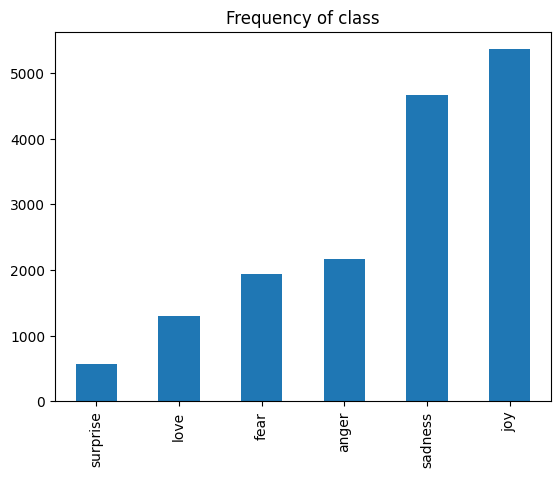

In [15]:
df['label_name'].value_counts(ascending=True).plot.bar()
plt.title('Frequency of class')
plt.show()

In [16]:
df['words_per_tweet'] = df['text'].str.split().apply(len)
df.head()

,text,label,label_name,words_per_tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


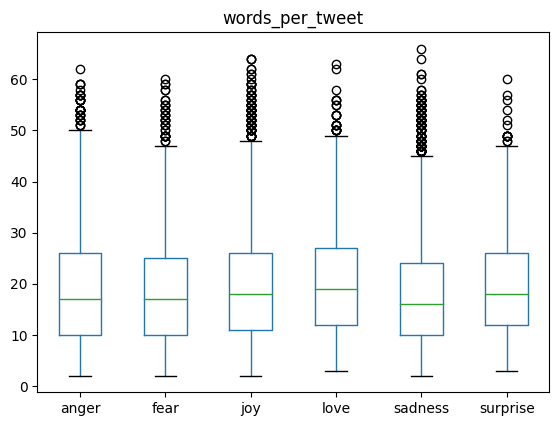

In [17]:
df.boxplot('words_per_tweet', by='label_name', grid=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

# Tokenizations

In [18]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [19]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [20]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [21]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [22]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [23]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [24]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

In [25]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [26]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

emotions.reset_format()
pp.pprint(tokenize(emotions['train'][:2]))

{'attention_mask': [[1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0],
                    [1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
               

In [27]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded['train'].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


In [28]:
from transformers import AutoModel
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
text = 'this is a test'
inputs = tokenizer(text, return_tensors='pt')
inputs['input_ids'].shape  # [ batch size, num tokens ]

torch.Size([1, 6])

In [30]:
inputs = {k: v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)

print(outputs.last_hidden_state.shape) # batch size, tokens, vector size of each tokens

torch.Size([1, 6, 768])


In [31]:
outputs.last_hidden_state[:, 0, :].shape

torch.Size([1, 768])

In [32]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [33]:
def extract_hidden_states(batch):
  inputs = {k: v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # Reutrn vector for [CLS] token by converting it to numpy array in cpu
  return {'hidden_state': last_hidden_state[:, 0, :].cpu().numpy()}

In [34]:
emotions_encoded.set_format('torch', 
                            columns=["input_ids", "attention_mask", "label"])

emotions_hidden_state = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [35]:
emotions_hidden_state['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [43]:
X_train = emotions_hidden_state['train']['hidden_state']
X_valid = emotions_hidden_state['validation']['hidden_state']
y_train = emotions_hidden_state['train']['label']
y_valid = emotions_hidden_state['validation']['label']
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

(torch.Size([16000, 768]),
 torch.Size([2000, 768]),
 torch.Size([16000]),
 torch.Size([2000]))

In [46]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.326871,6.478405,0
1,-3.018740,5.961348,0
2,5.348883,2.812623,3
3,-2.515260,3.515257,2
4,-3.330368,3.868566,3


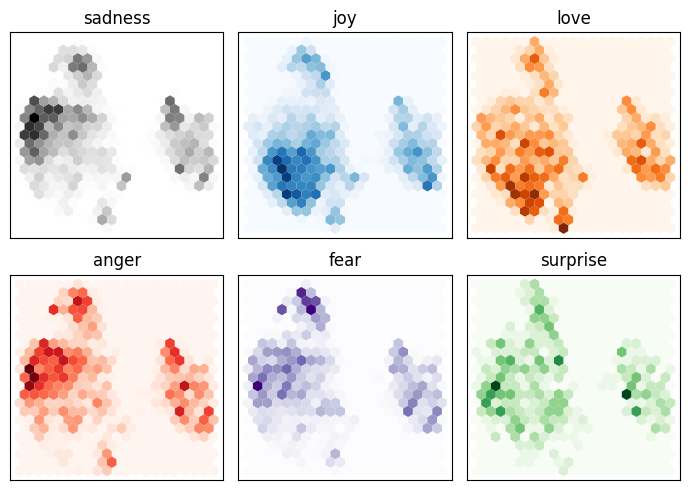

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
    gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

In [51]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [53]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Purples', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Normalized Confusion Matrix')
  plt.show()

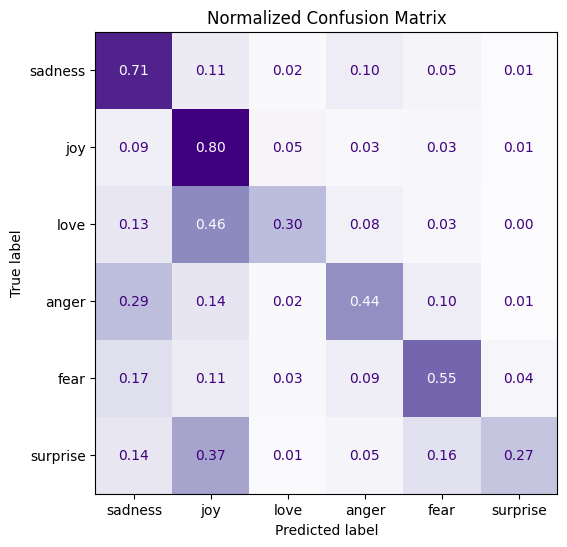

In [54]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine Tuning transformers

In [55]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification
.from_pretrained(model_ckpt, num_labels=num_labels)
.to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [57]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [58]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
          num_train_epochs=2,
          learning_rate=2e-5,
          per_device_train_batch_size=batch_size,
          per_device_eval_batch_size=batch_size,
          weight_decay=0.01,
          evaluation_strategy="epoch",
          disable_tqdm=False,
          logging_steps=logging_steps,
          push_to_hub=False,
          log_level="error")

In [59]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
compute_metrics=compute_metrics,
train_dataset=emotions_encoded["train"],
eval_dataset=emotions_encoded["validation"],
tokenizer=tokenizer)
trainer.train();

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.826600,0.314682,0.902000,0.899320
2,0.243500,0.219916,0.918500,0.918539


In [61]:
preds_output = trainer.predict(emotions_encoded['validation'])
preds_output

PredictionOutput(predictions=array([[ 4.5883327e+00, -2.4479929e-01, -8.9379525e-01, -1.0698371e+00,
        -9.7436124e-01, -1.6832719e+00],
       [ 4.6221280e+00, -6.1812121e-01, -1.3978466e+00, -9.4427693e-01,
        -3.0676463e-01, -1.6099138e+00],
       [-1.1266769e+00,  1.9311649e+00,  2.9901750e+00, -1.0276816e+00,
        -1.8367107e+00, -1.7881453e+00],
       ...,
       [-1.0174817e+00,  4.4607768e+00,  1.6047247e-01, -1.7512314e+00,
        -1.7596399e+00, -1.1413802e+00],
       [-1.3849349e+00,  2.5889721e+00,  2.7856197e+00, -1.3788801e+00,
        -1.8055840e+00, -1.7474494e+00],
       [-1.5014869e+00,  4.2008533e+00, -2.0983664e-03, -1.8780240e+00,
        -1.7037722e+00, -3.5502785e-01]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.2199159860610962, 'test_accuracy': 0.9185, 'test_f1': 0.9185386466278601, 'test_runtime': 4.4367, 'test_samples_per_second': 450.783, 'test_steps_per_second': 7.213})

In [62]:
preds_output.metrics

{'test_loss': 0.2199159860610962,
 'test_accuracy': 0.9185,
 'test_f1': 0.9185386466278601,
 'test_runtime': 4.4367,
 'test_samples_per_second': 450.783,
 'test_steps_per_second': 7.213}

In [66]:
preds_output.predictions.shape

(2000, 6)

In [68]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)
y_preds

array([0, 0, 2, ..., 1, 2, 1])

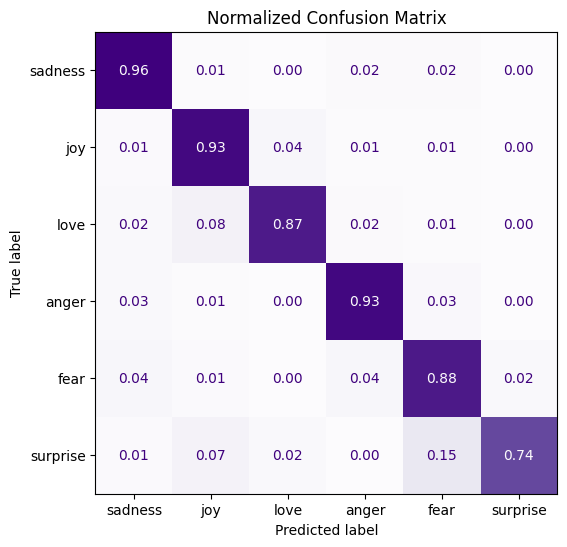

In [69]:
plot_confusion_matrix(y_preds, y_valid, labels)